<h1>Wrangle OpenStreetMap Data Project</h1>

I chose the harbor area of Westport Massechussetts because it is one of my favorite vacations spots to go bay fishing and sailing at. From my experience the area is predominantly wealthy people, vacationers, and sailors. 

Data wrangling techniques were used to transform and map the raw data into a database for further exploration. Checks for validity, accuracy, completeness of data, consistancy, and uniformity were made. Documentation of the procedure was done followed by an assessment of how to improve future data. Python and SQL were used in this process.

<h2>Westport Massechussetts</h2>

![Westport Massachussetts](WPSS2.jpg)

https://www.openstreetmap.org/export#map=11/41.5665/-71.0699

The OSM documentation shows that there are three main elements in the OpenStreetMap data: nodes, ways, and relations. Each element has tags that describe what each point is on the map.
<ul>
  <li>Nodes define points in space with an ID, latitude, and longitude.</li>
  <li>Ways define linear features and boundary areas using nodes. Linear examples are roads, rivers, trails, etc. Boundary area examples are national parks, theme parks, camp grounds, etc.</li>
  <li>Relations are ordered lists of data elements that describe the relationship between each other.</li>
</ul>


https://wiki.openstreetmap.org/wiki/Elements#Node

In [1]:
# Creating a sample file

import xml.etree.ElementTree as ET
import pprint
from collections import defaultdict
import re
import csv
import codecs
import cerberus
import schema

OSM_FILE = "WPM.osm"  
SAMPLE_FILE = "sample_WPM.osm"

# Parameter: take every k-th top level element
k = 42

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag
    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write(b'<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write(b'<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write(b'</osm>')

In [2]:
# Finding out what tags there are and how many of each


def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename, events=('start', )):
        if elem.tag not in tags:
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

def test():

    tags = count_tags('sample_WPM.osm')
    pprint.pprint(tags)
    

if __name__ == "__main__":
    test()

{'member': 33,
 'nd': 10707,
 'node': 9373,
 'osm': 1,
 'relation': 4,
 'tag': 3130,
 'way': 632}


In [3]:
# Checking "k" value for each tag and looking for potential problems

# 3 regular expressions I used to check for patterns in tags
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
# Checking for problematic characters
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


# Changing the data model into a dictionary
def key_type(element, keys):
    if element.tag == "tag":
        if lower.search(element.attrib['k']):
            keys['lower'] += 1
        elif lower_colon.search(element.attrib['k']):
            keys['lower_colon'] += 1
        elif problemchars.search(element.attrib['k']):
            keys['problemchars'] = keys['problemchars'] + 1
        else:    
            keys['other'] += 1  
#           print element.attrib['k']
    return keys


def process_keys_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

with open(OSM_FILE,'rb') as f:
    keys = process_keys_map(OSM_FILE)
    pprint.pprint(keys)
f.close() 

{'lower': 84411, 'lower_colon': 20640, 'other': 25527, 'problemchars': 0}


In [4]:
# Finding unique k (tag attrib['k']) and count

def unique_keys(filename):
    distinct_keys=[]
    count=1

    EL=get_element(filename, tags=('node', 'way', 'relation'))
    for element in EL:
        if element.tag=='node' or element.tag=='way':
            for tag in element.iter('tag'):
                if tag.attrib['k'] not in distinct_keys:
                    distinct_keys.append(tag.attrib['k'])
                    count+=1
    distinct_keys.sort()
    print("Total number of unique keys (tag attrib['k'])is {}".format(count))
    
#    return distinct_keys
      
    pprint.pprint(distinct_keys) # looks cleaner this way
    
                
#unique_keys(SAMPLE_FILE)  # Using Sample file as input to audit the addr:street key
unique_keys(OSM_FILE)  
#I used the sample file first and I became more curious and took a look at the whole file since it was not that big.

Total number of unique keys (tag attrib['k'])is 257
['access',
 'addr:city',
 'addr:country',
 'addr:housenumber',
 'addr:postcode',
 'addr:state',
 'addr:street',
 'addr:unit',
 'admin_level',
 'aeroway',
 'agricultural',
 'alt_name',
 'amenity',
 'area',
 'atm',
 'attribution',
 'barrier',
 'bench',
 'bicycle',
 'boundary',
 'boundary_type',
 'brand',
 'brand:wikidata',
 'brand:wikipedia',
 'bridge',
 'building',
 'building:levels',
 'cables',
 'capacity',
 'changing_table',
 'changing_table:location',
 'circuits',
 'clothes',
 'colour',
 'condition',
 'contact:email',
 'contact:website',
 'covered',
 'craft',
 'created_by',
 'cuisine',
 'cycleway:both',
 'cycleway:right',
 'destination',
 'destination:ref',
 'destination:street',
 'dispensing',
 'ele',
 'emergency',
 'entrance',
 'expressway',
 'faa',
 'fee',
 'fire_hydrant:position',
 'fire_hydrant:type',
 'foot',
 'frequency',
 'generator:method',
 'generator:source',
 'gnis:Class',
 'gnis:County',
 'gnis:County_num',
 'gnis:ST_al

In [5]:
#Finding values(tag attrib['v]) for unique k (tag attrib['k]) and making observation about the data

def values_for_unique_keys(filename):

        '''
        # Manually provide the item_name value from the list of distinct_keys to calculate 
        # the values for the corresponding unique key value. We would initialize the key 
        # variable with one value at a time and without iterating so that we could have an idea
        # of what sort of values are there for corresponding key value. Also, we would not iterate
        # as it would a long amount of time to calculate the values for all the corresponding unique
        # key value
        '''
        
        key='addr:street'
        values=[]
        EL=get_element(filename, tags=('node', 'way', 'relation'))
        for element in EL:
            for tag in element.iter('tag'):
                if tag.attrib['k']==key:
                    values.append(tag.attrib['v'])
            element.clear()
        print(key)
        pprint.pprint(values)

values_for_unique_keys(SAMPLE_FILE)  # Using Sample file as input to audit the addr:street key
#values_for_unique_keys(OSM_FILE)   # I could not find any errors with the sample so I looked at the whole.

addr:street
['State Road',
 'Potomska Road',
 'Faunce Corner Mall Road',
 'Rock Odundee Road',
 'Faunce Corner Road',
 'Shaker Road',
 'Howland Mill Lane',
 'South Brown Street',
 'Hixville Road',
 'Bellevue Street',
 'Green Drive',
 'Emmett Avenue',
 'Cross Road',
 'Elliot Street',
 'Rockville Avenue',
 'Gaffney Road',
 'Greystone Avenue',
 'Gaffney Road',
 'Cedar Avenue',
 'Juliette Street',
 'State Road',
 'State Road',
 'Old Westport Road',
 'Chase Road',
 'Longmeadow Road',
 'Chase Road',
 'Barneys Joy Road',
 'Azalea Drive',
 'Cross Road',
 'State Road',
 'Duane Avenue',
 'Yorke Street',
 'Horseneck Road',
 'Morton Avenue',
 'Yorke Street',
 'Hancock Street',
 'Fisher Road',
 'Woodcock Road',
 'Woodcock Road',
 'Elswick Street',
 'Hillcrest Street',
 'Lucy Little Road',
 'Fisher Road',
 'Fisher Road',
 'Slades Corner Road',
 'Horseneck Road',
 'Slades Farm Lane',
 'Division Road',
 'Division Road',
 'Division Road',
 'Christine Drive',
 'Fisher Road',
 'Eliza Lane',
 'Red Oak Lan

The street names look pretty consistent and clean here...

In [6]:
# How many unique users?

def get_user(element):
    return element.get('user')


def process_users_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        if element.get('user'):
            users.add(get_user(element))
        element.clear()    
    return users


with open(OSM_FILE,'rb') as f:
    users = process_users_map(OSM_FILE)

print(len(users))
# pprint.pprint(users) #curiosity
f.close()

457


In [7]:
"""
Your task in this exercise has two steps:

- audit the OSMFILE and change the variable 'mapping' to reflect the changes needed to fix 
    the unexpected street types to the appropriate ones in the expected list.
    You have to add mappings only for the actual problems you find in this OSMFILE,
    not a generalized solution, since that may and will depend on the particular area you are auditing.
- write the update_name function, to actually fix the street name.
    The function takes a string with street name as an argument and should return the fixed name
    We have provided a simple test so that you see what exactly is expected
"""
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

OSMFILE = "WPM.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road",
            "Trail", "Parkway", "Plaza", "Park"]


def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def print_sorted_dic(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print("%s: %d" % (k, v))

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit():

    street_types = defaultdict(set)
    for event, elem in ET.iterparse(OSMFILE, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    pprint.pprint(dict(street_types))

if __name__ == '__main__':
    audit()

{'6': {'Route 6'},
 'Acres': {'Hillcrest Acres'},
 'Circle': {'Brushwood Circle',
            'Captains Circle',
            'Christopher Circle',
            'Least Tern Circle'},
 'East': {'Horseneck Road East'},
 'Extension': {'Charlotte White Road Extension'},
 'Highway': {'American Legion Highway'},
 'Mall': {'North Dartmouth Mall'},
 'Path': {'Swan Pond Path', 'Woodcart Path', 'Hobbitt Hill Path'},
 'Pond': {'Allens Pond'},
 'Ridge': {'Hawks Nest Ridge'},
 'Row': {'Boathouse Row'},
 'Run': {'Blue Heron Run', 'Bent Oak Run', 'White Oak Run'},
 'Way': {'Abner Potters Way',
         'Aimes Way',
         'Amory Pettey Way',
         'Attatash Way',
         'Brayton Way',
         'Bridle Way',
         'Brothers Way',
         'Carters Way',
         'Cedar Dell Way',
         "Cheryl's Way",
         'Clydes Way',
         'Elihu Way',
         'Elise Michelle Way',
         'Fisher Pines Way',
         'Flores Way',
         'Gels Way',
         'Grand Pine Way',
         'Hebert

In [8]:
mapping = {"St": "Street",
           "ST": "Street",
           "St.": "Street",
           "St,": "Street",
           "Street.": "Street",
           "street": "Street",
           "Sq": "Square",
           "Rd.": "Road",
           "Rd": "Road",
           "Ave": "Avenue",
           "DR.": "Drive"
           }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osmfile, events=("start",)):

        if elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types


def update_name(name, mapping):
    for key, value in mapping.items():
        if re.search(key, name):
            name = re.sub(street_type_re, value, name)

    return name


def test():
    st_types = audit(OSMFILE)
    for st_type, ways in st_types.items():
        for name in ways:
            better_name = update_name(name, mapping)
            print (name, "=>", better_name)


if __name__ == '__main__':
    test()

Ridgeline Drive West => Ridgeline Drive West
Gulf Road West => Gulf Road West
North Dartmouth Mall => North Dartmouth Mall
Whalers Way => Whalers Way
Hersheys Way => Hersheys Way
Loretta Way => Loretta Way
Walters Way => Walters Way
Maya Way => Maya Way
Aimes Way => Aimes Way
Thistle Dew Way => Thistle Dew Way
Jordans Way => Jordans Way
Windward Way => Windward Way
Julius Way => Julius Way
Swartzs Way => Swartzs Way
Cedar Dell Way => Cedar Dell Way
Rileys Way => Rileys Way
Flores Way => Flores Way
Cheryl's Way => Cheryl's Way
Grand Pine Way => Grand Pine Way
Elihu Way => Elihu Way
Spinnaker Way => Spinnaker Way
Tootell Way => Tootell Way
Amory Pettey Way => Amory Pettey Way
Scotts Way => Scotts Way
Kelseys Way => Kelseys Way
Clydes Way => Clydes Way
Smiths Way => Smiths Way
Soules Way => Soules Way
Brayton Way => Brayton Way
Stonehaven Way => Stonehaven Street
Brothers Way => Brothers Way
Elise Michelle Way => Elise Michelle Way
Roller Coaster Way => Roller Coaster Way
Nicks Way => Nic

In [9]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

"""I am following the same procedure as in the audit_street_type.py
script, but this time I will audit and update amenities. The only difference
with the audit_street_type.py script is that I won't use the title method
because the amenities names are found in lowercase letters in the OpenStreetMap
dataset."""

osmfile = "WPM.osm"
amenity_re = re.compile(r'\S+(\s\S+)*')
amenity = defaultdict(set)

#https://wiki.openstreetmap.org/wiki/Key:amenity

expected_amenities = ["bar", "biergarten", "cafe", "fast_food", "pub", "restaurant", "school", "university",
                     "boat_rental", "boat_sharing", "parking", "taxi", "atm", "bank", "hospital", "pharmacy",
                     "fire_station", "police", "post_office", "townhall", "water_point", "gym", "martketplace",
                     "internet_cafe", "place_of_worship", "user defined"]

			
def audit_amenities(amenity, amenity_name):
    n = amenity_re.search(amenity_name)
    if n:
        amenity_found = n.group()
        if amenity_found not in expected_amenities:
        	amenity[amenity_found].add(amenity_name)

def is_amenity(elem):
    return (elem.attrib['k'] == "amenity")

def audit_amenity():
    osm_file = open(osmfile, "rb")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_amenity(tag):
                    audit_amenities(amenity, tag.attrib['v'])
    pprint.pprint(dict(amenity))
    #amenity


amenity_mapping = {
                    "fastfood": "fast_food", 
                    "New American": "restaurant",
                    "police; council": "police" 
    		      }
                      
def update_amenity(name, amenity_mapping):
    for amenity in amenity_mapping:
        if amenity in name:
            name = re.sub(r'\b' + re.escape(amenity), amenity_mapping[amenity], name)
    return name


if __name__ == '__main__':
    audit_amenity()

{'bicycle_parking': {'bicycle_parking'},
 'cinema': {'cinema'},
 'food_court': {'food_court'},
 'fuel': {'fuel'},
 'library': {'library'},
 'post_box': {'post_box'},
 'public_building': {'public_building'},
 'toilets': {'toilets'}}


In [37]:
# my_schema.py

SCHEMA = {
    'node': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
            }
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
            }
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}

In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
After auditing is complete the next step is to prepare the data to be inserted into a SQL database.
To do so you will parse the elements in the OSM XML file, transforming them from document format to
tabular format, thus making it possible to write to .csv files.  These csv files can then easily be
imported to a SQL database as tables.

The process for this transformation is as follows:
- Use iterparse to iteratively step through each top level element in the XML
- Shape each element into several data structures using a custom function
- Utilize a schema and validation library to ensure the transformed data is in the correct format
- Write each data structure to the appropriate .csv files

We've already provided the code needed to load the data, perform iterative parsing and write the
output to csv files. Your task is to complete the shape_element function that will transform each
element into the correct format. To make this process easier we've already defined a schema (see
the schema.py file in the last code tab) for the .csv files and the eventual tables. Using the 
cerberus library we can validate the output against this schema to ensure it is correct.

## Shape Element Function
The function should take as input an iterparse Element object and return a dictionary.

### If the element top level tag is "node":
The dictionary returned should have the format {"node": .., "node_tags": ...}

The "node" field should hold a dictionary of the following top level node attributes:
- id
- user
- uid
- version
- lat
- lon
- timestamp
- changeset
All other attributes can be ignored

The "node_tags" field should hold a list of dictionaries, one per secondary tag. Secondary tags are
child tags of node which have the tag name/type: "tag". Each dictionary should have the following
fields from the secondary tag attributes:
- id: the top level node id attribute value
- key: the full tag "k" attribute value if no colon is present or the characters after the colon if one is.
- value: the tag "v" attribute value
- type: either the characters before the colon in the tag "k" value or "regular" if a colon
        is not present.

Additionally,

- if the tag "k" value contains problematic characters, the tag should be ignored
- if the tag "k" value contains a ":" the characters before the ":" should be set as the tag type
  and characters after the ":" should be set as the tag key
- if there are additional ":" in the "k" value they and they should be ignored and kept as part of
  the tag key. For example:

  <tag k="addr:street:name" v="Lincoln"/>
  should be turned into
  {'id': 12345, 'key': 'street:name', 'value': 'Lincoln', 'type': 'addr'}

- If a node has no secondary tags then the "node_tags" field should just contain an empty list.

The final return value for a "node" element should look something like:

{'node': {'id': 757860928,
          'user': 'uboot',
          'uid': 26299,
       'version': '2',
          'lat': 41.9747374,
          'lon': -87.6920102,
          'timestamp': '2010-07-22T16:16:51Z',
      'changeset': 5288876},
 'node_tags': [{'id': 757860928,
                'key': 'amenity',
                'value': 'fast_food',
                'type': 'regular'},
               {'id': 757860928,
                'key': 'cuisine',
                'value': 'sausage',
                'type': 'regular'},
               {'id': 757860928,
                'key': 'name',
                'value': "Shelly's Tasty Freeze",
                'type': 'regular'}]}

### If the element top level tag is "way":
The dictionary should have the format {"way": ..., "way_tags": ..., "way_nodes": ...}

The "way" field should hold a dictionary of the following top level way attributes:
- id
-  user
- uid
- version
- timestamp
- changeset

All other attributes can be ignored

The "way_tags" field should again hold a list of dictionaries, following the exact same rules as
for "node_tags".

Additionally, the dictionary should have a field "way_nodes". "way_nodes" should hold a list of
dictionaries, one for each nd child tag.  Each dictionary should have the fields:
- id: the top level element (way) id
- node_id: the ref attribute value of the nd tag
- position: the index starting at 0 of the nd tag i.e. what order the nd tag appears within
            the way element

The final return value for a "way" element should look something like:

{'way': {'id': 209809850,
         'user': 'chicago-buildings',
         'uid': 674454,
         'version': '1',
         'timestamp': '2013-03-13T15:58:04Z',
         'changeset': 15353317},
 'way_nodes': [{'id': 209809850, 'node_id': 2199822281, 'position': 0},
               {'id': 209809850, 'node_id': 2199822390, 'position': 1},
               {'id': 209809850, 'node_id': 2199822392, 'position': 2},
               {'id': 209809850, 'node_id': 2199822369, 'position': 3},
               {'id': 209809850, 'node_id': 2199822370, 'position': 4},
               {'id': 209809850, 'node_id': 2199822284, 'position': 5},
               {'id': 209809850, 'node_id': 2199822281, 'position': 6}],
 'way_tags': [{'id': 209809850,
               'key': 'housenumber',
               'type': 'addr',
               'value': '1412'},
              {'id': 209809850,
               'key': 'street',
               'type': 'addr',
               'value': 'West Lexington St.'},
              {'id': 209809850,
               'key': 'street:name',
               'type': 'addr',
               'value': 'Lexington'},
              {'id': '209809850',
               'key': 'street:prefix',
               'type': 'addr',
               'value': 'West'},
              {'id': 209809850,
               'key': 'street:type',
               'type': 'addr',
               'value': 'Street'},
              {'id': 209809850,
               'key': 'building',
               'type': 'regular',
               'value': 'yes'},
              {'id': 209809850,
               'key': 'levels',
               'type': 'building',
               'value': '1'},
              {'id': 209809850,
               'key': 'building_id',
               'type': 'chicago',
               'value': '366409'}]}
"""

import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET
import cerberus
import schema

from my_schema import SCHEMA

OSM_PATH = "WPM.osm"
file_in = open("WPM.osm")
root = ET.parse("WPM.osm").getroot()

def find_element():
    element = []
    for item in root.find("node"):
        element = ET.dump(item)
        return element
    
element = find_element
    
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema.SCHEMA

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

  
    if element.tag == 'node':

            for node_field in node_attr_fields:
                node_attribs[node_field] = element.attrib[node_field]

            for tag in element.iter('tag'):
                k = tag.attrib['k']

                # ignores tags containing problem characters in the k tag attribute:

                if re.search(PROBLEMCHARS,k):
                    continue
                else:
                    pass

                tag_dict = {}

                tag_dict['id'] = node_attribs['id']

                colon_find = re.split('[:]', k)

                if len(colon_find) == 1:

                    tag_dict['key'] = k
                    tag_dict['type'] = 'regular'

                elif len(colon_find) == 2:

                    tag_dict['key'] = colon_find[1]
                    tag_dict['type'] = colon_find[0]

                elif len(colon_find) > 2:

                    tag_dict['key'] = ':'.join(colon_find[1:])
                    tag_dict['type'] = colon_find[0]

                tag_dict['value'] = tag.attrib['v']

                tags.append(tag_dict)

            return {'node': node_attribs, 'node_tags': tags}

    elif element.tag == 'way':

        for way_field in way_attr_fields:
            way_attribs[way_field] =element.attrib[way_field]

        for tag in element.iter('tag'):
            k = tag.attrib['k']

            # ignores tags containing problem characters in the k tag attribute:

            if re.search(PROBLEMCHARS,k):
                print ("Problem character found - skipping element")
                continue
            else:
                pass

            tag_dict = {}

            tag_dict['id'] = way_attribs['id']

            colon_find = re.split('[:]', k)

            if len(colon_find) == 1:

                tag_dict['key'] = k
                tag_dict['type'] = 'regular'

            elif len(colon_find) == 2:

                tag_dict['key'] = colon_find[1]
                tag_dict['type'] = colon_find[0]

            elif len(colon_find) > 2:

                tag_dict['key'] = ':'.join(colon_find[1:])
                tag_dict['type'] = colon_find[0]

            tag_dict['value'] = tag.attrib['v']

            tags.append(tag_dict)

        n = 0
        for nd in element.iter('nd'):

            nd_dict = {}

            nd_dict['id'] = way_attribs['id']
            nd_dict['node_id'] = nd.attrib['ref']
            nd_dict['position'] = n
            way_nodes.append(nd_dict)
            n+=1

        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: v for k, v in row.items()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w', "utf-8") as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w', "utf-8") as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w', "utf-8") as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w', "utf-8") as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w', "utf-8") as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':

    process_map(OSM_PATH, validate=True)
    
print("Reshaped and exported.") 

Reshaped and exported.


In [10]:
import sqlite3
"""import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)"""
conn = sqlite3.connect('WPM.db')
cursor = conn.cursor()
print("Opened database successfully")

Opened database successfully


In [15]:
# Self note - Do not need to re-create them every time.

#https://www.sqlitetutorial.net/sqlite-python/create-tables/

import sqlite3
from sqlite3 import Error


def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)


def main():
    database = r"C:\Users\wille\WPM.db"

    sql_create_nodes_table = """ CREATE TABLE IF NOT EXISTS nodes (
        id INTEGER PRIMARY KEY NOT NULL,
        lat FLOAT,
        lon FLOAT,
        user TEXT,
        uid INTEGER,
        version TEXT,
        changeset INTEGER,
        timestamp TEXT
    );"""

    sql_create_nodes_tags_table = """CREATE TABLE IF NOT EXISTS nodes_tags (
        id INTEGER,
        key TEXT,
        value TEXT,
        type TEXT,
        FOREIGN KEY (id) REFERENCES nodes(id)
    );"""


    sql_create_ways_table = """CREATE TABLE IF NOT EXISTS ways (
         id INTEGER PRIMARY KEY NOT NULL,
         user TEXT,
         uid INTEGER,
         version TEXT,
         changeset INTEGER,
         timestamp TEXT
     );"""

    sql_create_ways_tags_table = """CREATE TABLE IF NOT EXISTS ways_tags (
         id INTEGER NOT NULL,
         key TEXT NOT NULL,
         value TEXT NOT NULL,
         type TEXT,
         FOREIGN KEY (id) REFERENCES ways(id)
     );"""

    sql_create_ways_nodes_table = """CREATE TABLE IF NOT EXISTS ways_nodes (
         id INTEGER NOT NULL,
         node_id INTEGER NOT NULL,
         position INTEGER NOT NULL,
         FOREIGN KEY (id) REFERENCES ways(id),
         FOREIGN KEY (node_id) REFERENCES nodes(id)
     );"""


    # create a database connection
    conn = create_connection(database)

     # create tables
    if conn is not None:
         # create nodes table
        create_table(conn, sql_create_nodes_table)

         # create nodes tags table
        create_table(conn, sql_create_nodes_tags_table)
        
         # create ways table
        create_table(conn, sql_create_ways_table)

         # create ways tags table
        create_table(conn, sql_create_ways_tags_table)

         # create ways nodes table
        create_table(conn, sql_create_ways_nodes_table)
       
    else:
        print("Error! cannot create the database connection.")


if __name__ == '__main__':
    main()

In [ ]:
# SQL used...
# sqlite3 WPM.db
# .tables
# .schema nodes
# .schema nodes_tags
# .schema ways
# .schema ways_nodes
# .schema ways_tags
# .mode csv
# .import nodes.csv nodes
# .import nodes_tags.csv nodes_tags
# .import ways.csv ways
# .import ways_nodes.csv ways_nodes
# .import ways_tags.csv ways_tags
# SELECT COUNT(id) FROM nodes;

# this was to double check that they all imported correctly
# I ran into situations where I had to start over and double check my work from things not loading properly

In [25]:
import os
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

sz_OSM = os.path.getsize("WPM.osm")
sz_nodes = os.path.getsize("nodes.csv")
sz_nodes_tags = os.path.getsize("nodes_tags.csv")
sz_ways = os.path.getsize("ways.csv")
sz_ways_nodes = os.path.getsize("ways_nodes.csv")
sz_ways_tags = os.path.getsize("ways_tags.csv")
sz_DB = os.path.getsize("WPM.db")


# creating a DataFrame of file sizes
dict = {'File Size':['WPM.osm', 'nodes.csv', 'nodes_tags.csv', 'ways.csv', 'ways_nodes.csv', 'ways_tags.csv'],
		'Bytes':[sz_OSM, sz_nodes, sz_nodes_tags, sz_ways, sz_ways_nodes, sz_ways_tags]}

df = pd.DataFrame(dict)

display(df)


,File Size,Bytes
0,WPM.osm,86583659
1,nodes.csv,34062678
2,nodes_tags.csv,3022818
3,ways.csv,1739787
4,ways_nodes.csv,11764383
5,ways_tags.csv,3192117


In [26]:
# number of unique users

cursor.execute("SELECT COUNT( DISTINCT uid) as Users FROM nodes;")
rows = cursor.fetchall()
unique_users = pd.DataFrame(rows, columns=['Users'])
unique_users

,Users
0,431


In [27]:
# number of nodes

cursor.execute("SELECT COUNT(id) as Nodes FROM nodes;")
rows = cursor.fetchall()
Nodes = pd.DataFrame(rows, columns=['Nodes'])
Nodes

,Nodes
0,393654


In [22]:
# number of ways

cursor.execute("SELECT COUNT(id) as Ways FROM ways;")
rows = cursor.fetchall()
Ways = pd.DataFrame(rows, columns=['Ways'])
Ways

,Ways
0,26522


In [18]:
#top 10 user contributors

cursor.execute("SELECT uid, user, sum(count) as count FROM \
               (SELECT uid, user, count(*) as count FROM nodes GROUP BY uid \
               UNION \
               SELECT uid, user, count(*) as count FROM ways GROUP BY uid) \
               GROUP BY uid \
               ORDER BY count DESC LIMIT 10;")
rows = cursor.fetchall()
users = pd.DataFrame(rows, columns=['User ID', 'User Name', 'Count'])
users

,User ID,User Name,Count
0,221294,morganwahl,159362
1,1137433,jremillard-massgis,112960
2,219297,ZeLonewolf,38122
3,1034,crschmidt,22769
4,15750,MassGIS Import,19036
5,2407685,Zirnch,17633
6,8980145,Alan_Bragg_Import,8620
7,411298,Yury Yatsynovich,4619
8,443130,Alan Bragg,3562
9,147510,woodpeck_fixbot,2927


In [4]:
#most common node tags
cursor.execute("SELECT key,count(*) FROM nodes_tags \
                GROUP BY 1 \
                ORDER BY count(*) DESC \
                LIMIT 10;")
rows = cursor.fetchall()
node_keys = pd.DataFrame(rows, columns=['Node Tags', 'Count'])
node_keys

,Node Tags,Count
0,source,19468
1,attribution,19458
2,power,559
3,name,190
4,highway,173
5,ele,127
6,feature_id,96
7,created,93
8,barrier,83
9,created_by,81


In [5]:
#most common amenities
cursor.execute("SELECT value, sum(count) as count FROM \
               (SELECT value, count(*) as count FROM nodes_tags WHERE key = 'amenity' \
               GROUP BY value \
               UNION \
               SELECT value, count(*) as count FROM ways_tags WHERE key = 'amenity' \
               GROUP BY value) \
               GROUP BY value ORDER BY count desc LIMIT 20;")
rows = cursor.fetchall()
amenities = pd.DataFrame(rows, columns=['Amenity', 'Count'])
amenities

,Amenity,Count
0,parking,75
1,restaurant,10
2,school,9
3,fast_food,9
4,place_of_worship,7
5,post_office,5
6,fire_station,5
7,cafe,5
8,library,3
9,fuel,3


In [37]:
# Most common religions in the area

cursor.execute("SELECT nodes_tags.value, COUNT(*) as num \
                FROM nodes_tags \
                JOIN (SELECT DISTINCT(id) \
                FROM nodes_tags \
                WHERE value='place_of_worship') i \
                ON nodes_tags.id=i.id \
                WHERE nodes_tags.key='religion' \
                GROUP BY nodes_tags.value \
                ORDER BY num DESC;")
results = cursor.fetchall()
results

[('christian', 7)]

In [30]:
"""
Creates labels and percentage labels for matplotlib.pie().'
Authors: Mark Bannister (make_labels), 'unutbu' (make_autopct)
Source: http://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
"""

def make_labels(categories,values):
    """Make pie chart labels with category names and values.
    Args:
        categories (list): list of pie chart categories.
        values (list): list of pie chart values.
    Returns:
        labels (list): list of pie chart labels in the format "Category (Value)".
    """
    labels = []
    for i in range(0, len(values)):
        labels.append("{c} ({v})".format(c=categories[i], v=values[i]))
    return labels

def make_autopct(values):
    """Make pie chart autopct labels.
    Args:
        values (list): list of pie chart values.
    Returns:
        my_autopct (function): function to pass to autopct parameter.
    """
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%'.format(p=pct,v=val)
    return my_autopct

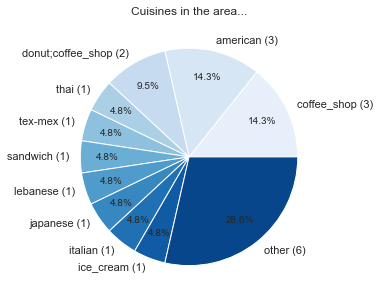

In [36]:
#Preparing the data

cursor.execute("SELECT sum(count) FROM \
               (SELECT count(*) as count FROM nodes_tags WHERE key = 'cuisine' \
               UNION SELECT count(*) as count FROM ways_tags WHERE key = 'cuisine');")
total_cuisines = cursor.fetchone()[0]

cursor.execute("SELECT value, sum(count) as count FROM \
               (SELECT value, count(*) as count FROM nodes_tags WHERE key = 'cuisine' \
               GROUP BY value \
               UNION \
               SELECT value, count(*) as count FROM ways_tags WHERE key = 'cuisine' \
               GROUP BY value) \
               GROUP BY value ORDER BY count desc LIMIT 10;")
rows = cursor.fetchall()
cuisines = pd.DataFrame(rows, columns=['Cuisine', 'Count'])
#cuisines # checking the dataframe

# Make the pie chart

values = list(cuisines['Count']) + [(total_cuisines - sum(cuisines['Count']))]
categories = list(cuisines['Cuisine']) + ['other']
labels = make_labels(categories,values)
colors=sns.color_palette("Blues",11)
plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(values, labels=labels, colors=colors, \
                                    autopct=make_autopct(values), pctdistance=0.75)
for i in range(0,len(autotexts)):
    autotexts[i].set_fontsize(10)
plt.title("Cuisines in the area...")
plt.show()

#https://datatofish.com/pie-chart-matplotlib/

There seems to be some human errors for restuarant, cafes, bars, pubs, etc. with categorizing their cuisines. As you can see on the pie chart, there are two seperate sections showing coffee shops...

My idea to help refine this process and try to minimize error is to have every landlord/building owner fill out a standardized entry of the business details of the building upon purchase of the building. This information will then be documented into the streetmap data. To cross check and keep this information up to date, census eployees or volunteers who go door to door collecting demographical information can audit this information one building at a time every year. 

<h4>Problems...</h4>
<ul>
  <li>More human error such as not paying attention to the fields that information is being listed under or people just not caring.</li>
  <li>Condemned or run down buildings where there is nobody to answer the door.</li>
  <li>Private properties with locked gates.</li>
</ul>

<h4>Benefits...</h4>
<ul>
  <li>More colaboration and more eyes on the data.</li>
  <li>Potential for more up to date data thereby minimizing data corrections.</li>
</ul>